In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import numpy as np
path = 'testset.csv'
df = pd.read_csv(path)
# verisetinde her bir column ' ' boşluk ile başladığı için stripliyoruz
df.columns = df.columns.str.strip()
# datetime.csv de farklı bir formatta verildiği için pd içindeki to datetime ile düzenliyoruz
df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])

# her günün 15:00' da kaydedilmiş hava durumunu alıyoruz
df = df[df['datetime_utc'].dt.hour == 15]


### B. Sürecin Durum Uzayı (S) ve Zaman Parametresi (T)

**Durum Uzayı (S):** 



- Haze: Pus
- Mist: Sis
- Smoke: Duman
- Widespread Dust: Yaygın Toz
- Light Rain: Hafif Yağmur
- Clear: Açık hava, bulutsuz








Bu elemanlar hava durumu koşullarını ifade ediyor ve sürecin durum uzayını tanımlar. Sürecin durum uzayı, belirttiğimiz hava durumu koşullarının kümesidir:

S = { Haze, Mist, Smoke, Widespread Dust, Light Rain, Clear }

**Zaman Parametresi (T):**


\( T = \{ 0, 1, 2, 3, ... , n - 1 \} \)

Burada \( n \), veri setimizdeki satır sayısını temsil eder. Biz spesifik olarak 1996 dan 2017 ye kadar gün gün veriyi aldık

### B. Sürecin Durumlarını Tanımlama ve Durumları Belirleme Kararı

**Sürecin Durumlarını Tanımlama:**

Sürecin durumları, belirttiğiniz hava durumu koşulları (`_conds` sütunu) tarafından tanımlanır. Bu durumlar sürecin durum uzayını oluşturur:

- Haze
- Mist
- Smoke
- Widespread Dust
- Light Rain
- Clear

**Durumları Belirleme Kararı:**

Durumları belirlerken, `_conds` sütununda verilen hava durumu koşullarını dikkate aldık. Belirttiğimiz hava durumu koşulları, hava durumu veri setimizde bulunan belirli elemanlar:

- Bu elemanlar, hava durumu koşullarının belirtilen sınıflarını temsil ediyor. Veri çerçevemizde farklı hava durumları içeren koşullar da vardı ancak biz en çok 5 koşulu tercih ettik



In [7]:
# burada en çok raslanan 5 hava durumunu ele alacağız.
df['_conds'].value_counts()

Haze                            3735
Mist                            1259
Smoke                            931
Widespread Dust                  208
Light Rain                       103
Clear                             89
Partly Cloudy                     88
Shallow Fog                       67
Patches of Fog                    66
Fog                               58
Scattered Clouds                  56
Partial Fog                       54
Thunderstorms and Rain            53
Mostly Cloudy                     43
Light Drizzle                     36
Thunderstorm                      22
Unknown                           18
Rain                              18
Blowing Sand                      15
Heavy Fog                         13
Light Thunderstorm                13
Overcast                          10
Light Thunderstorms and Rain      10
Drizzle                            3
Light Fog                          3
Squalls                            1
Light Sandstorm                    1
N

In [8]:
df

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
27,1996-11-02 15:00:00,Smoke,12.0,0,0,NaN,56.0,NaN,1010.0,0,0,21.0,0,0,NaN,0.0,North,NaN,NaN,NaN
51,1996-11-03 15:00:00,Smoke,13.0,0,0,NaN,60.0,NaN,1011.0,0,0,21.0,0,0,1.5,0.0,North,NaN,NaN,0.0
91,1996-11-06 15:00:00,Smoke,10.0,0,0,NaN,56.0,NaN,1013.0,0,0,19.0,0,0,NaN,0.0,North,NaN,NaN,NaN
114,1996-11-07 15:00:00,Smoke,9.0,0,0,NaN,49.0,NaN,1014.0,0,0,20.0,0,0,1.5,0.0,North,NaN,NaN,0.0
138,1996-11-08 15:00:00,Smoke,9.0,0,0,NaN,49.0,NaN,1015.0,0,0,20.0,0,0,1.2,0.0,North,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100954,2017-04-20 15:00:00,Haze,21.0,0,0,NaN,36.0,NaN,997.0,0,0,34.0,0,0,2.0,NaN,NaN,NaN,NaN,0.0
100962,2017-04-21 15:00:00,Haze,22.0,0,0,NaN,38.0,NaN,999.0,0,0,35.0,0,0,2.0,90.0,East,NaN,NaN,1.9
100972,2017-04-22 15:00:00,Haze,20.0,0,0,NaN,41.0,NaN,1001.0,0,0,32.0,0,0,2.0,NaN,NaN,NaN,NaN,0.0
100980,2017-04-23 15:00:00,Haze,18.0,0,0,NaN,32.0,NaN,1001.0,0,0,33.0,0,0,2.0,NaN,NaN,NaN,NaN,0.0


### C) Bir Adım Geçiş Matrisi

In [9]:
# en çok raslanan 5 eleman
elemanlar = [
    'Haze',
    'Mist',
    'Smoke',
    'Widespread Dust',
    'Light Rain',
    'Clear'
]


df = df[df['_conds'].isin(elemanlar)]

transition_dict = {eleman: {k: 0 for k in elemanlar} for eleman in elemanlar}


for i in range(len(df) - 1):
    current_condition = df['_conds'].iloc[i]
    next_condition = df['_conds'].iloc[i + 1]
    if current_condition in elemanlar and next_condition in elemanlar:
        transition_dict[current_condition][next_condition] += 1


transition_matrix = pd.DataFrame.from_dict(transition_dict)


transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0).round(4)

transition_matrix

,Haze,Mist,Smoke,Widespread Dust,Light Rain,Clear
Haze,0.8458,0.0715,0.0469,0.0155,0.0134,0.0070
Mist,0.2176,0.7061,0.0469,0.0008,0.0286,0.0000
Smoke,0.1720,0.0817,0.7204,0.0011,0.0011,0.0237
Widespread Dust,0.3125,0.0000,0.0000,0.6490,0.0192,0.0192
Light Rain,0.5340,0.2524,0.0291,0.0485,0.1165,0.0194
Clear,0.2360,0.0112,0.2697,0.0899,0.0000,0.3933


### D. Bir Adım Geçiş Diyagramını Çiziniz

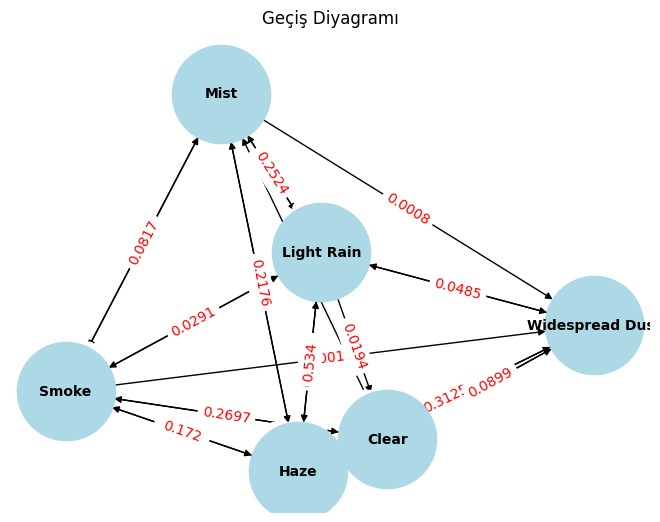

In [10]:

G = nx.DiGraph()


for from_node in transition_matrix.index:
    for to_node in transition_matrix.columns:
        weight = transition_matrix.loc[from_node, to_node]
        if weight > 0:
            G.add_edge(from_node, to_node, weight=weight)


pos = nx.spring_layout(G, seed=100)  
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
labels = nx.get_edge_attributes(G, 'weight')


nx.draw(G, pos, with_labels=True, node_size=5000, node_color='lightblue', font_size=10, font_color='black', font_weight='bold')


nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, arrowstyle='->')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')

plt.title('Geçiş Diyagramı')


plt.show()
plt.show()

# https://stackoverflow.com/questions/32652149/combine-join-networkx-graphs

### E)  P matrisinden faydalanarak denge dağılımını bulma 

In [11]:
matrix = transition_matrix.to_numpy()
matrix_T = np.transpose(matrix)
eigenvalues, eigenvectors = np.linalg.eig(matrix_T)
idx = np.isclose(eigenvalues, 1).argmax()

steady_state = eigenvectors[:, idx].real

steady_state = steady_state / np.sum(steady_state)

steady_state_df = pd.DataFrame(steady_state, index=transition_matrix.columns, columns=["Denge Dağılımı"])
steady_state_df

#https://stackoverflow.com/questions/52137856/steady-state-probabilities-markov-chain-python-implementation

,Denge Dağılımı
Haze,0.590006
Mist,0.199074
Smoke,0.147660
Widespread Dust,0.032837
Light Rain,0.016289
Clear,0.014134


### F) P<sup>2</sup> iki adım geçiş matrisini bulma 



In [12]:
iki_adim_gecis_matrisi = np.matmul(transition_matrix.values, transition_matrix.values) # matmul ile trans. matrisi kendisiyle carpıyoruz


iki_adim_gecis_matrisi_df= pd.DataFrame(iki_adim_gecis_matrisi, index=transition_matrix.index, columns=transition_matrix.columns).round(4)


iki_adim_gecis_matrisi_df

,Haze,Mist,Smoke,Widespread Dust,Light Rain,Clear
Haze,0.7527,0.1183,0.0791,0.0246,0.0153,0.0103
Mist,0.3613,0.5252,0.0779,0.0059,0.0265,0.0032
Smoke,0.2937,0.1294,0.5373,0.0064,0.0056,0.0276
Widespread Dust,0.4819,0.0274,0.0204,0.4287,0.0189,0.0226
Light Rain,0.5935,0.2484,0.0665,0.0474,0.0289,0.0152
Clear,0.3693,0.0512,0.3120,0.0977,0.0055,0.1645


### 2. Soru Periyodik durum içeren bir Markov zincirine ait geçiş olasılık diyagramını çiziniz ve bir- adım geçiş matrisi (P)’yi yazınız.


Öncelikle periyodik bir Markov zincirinin nasıl göründüğüne dair bir örnek diyagram çizelim:

```
Durumlar:
- Durum 0
- Durum 1
- Durum 2

Durum 0 --(p_01)--> Durum 1
Durum 1 --(p_12)--> Durum 2
Durum 2 --(p_20)--> Durum 0
```

Burada:
- `Durum 0`, `Durum 1` ve `Durum 2` isimli durumlar zincirin farklı durumlarıdır.
- `p_01`, `Durum 0`'dan `Durum 1`'e geçiş olasılığıdır.
- `p_12`, `Durum 1`'den `Durum 2`'ye geçiş olasılığıdır.
- `p_20`, `Durum 2`'den `Durum 0`'a geçiş olasılığıdır.

Bir- adım geçiş matrisi (P) aşağıdaki gibi yazılabilir:

```markdown
P = | p_00 p_01 p_02 |
    | p_10 p_11 p_12 |
    | p_20 p_21 p_22 |

P = | 0    1    0   |
    | 0    0    1   |
    | 1    0    0   |
```

- Matriste satır başına toplam geçiş olasılıklarının toplamı 1 olmalıdır.
- Yukarıdaki geçiş matrisi, her durumdan bir sonraki duruma olan geçişleri ifade eder.
- `p_00` ve `p_11`'in 0 olması, periyodik olma özelliğini gösterir.

Burada bir- adım geçiş matrisi (P) özellikle belirtilen durumlardan diğerlerine olan geçiş olasılıklarını göstermektedir. Bu örnekte periyodikliği gözlemleyebiliriz.

### 3) Yutucu durum/durumlar içeren bir Markov zincirine ait olasılık diyagramını çiziniz ve bir- adım geçiş matrisi *(P)* ’yi tanımlayınız.
Bu örnekte, yutucu durumun bir örneği olarak "kasvetli" ya da "kapalı" bir hava durumu durumu düşünebiliriz. Bu durum, dış dünyadan (örneğin, bir meteorolojik modelde kullanılan diğer verilerden) etkilenen ancak dış dünyaya doğrudan geri etki yapmayan bir durumu temsil eder.

Örneğin, güneşli bir günün ardından genellikle birkaç gün bulutlu olabilir. Bu durumda, "bulutlu" hava durumu, yutucu durum olacaktır. Çünkü "bulutlu" durumu, dış dünyadan (güneşli günlerin ardışık olması gibi) gelen etkilerle belirlenir, ancak bu durum doğrudan dış dünyaya geri etki yapmaz. Yani, güneşli bir günün ardından kaç gün bulutlu olacağını tahmin ederken, yutucu durum olan bulutlu günler arasındaki geçişleri inceleriz.

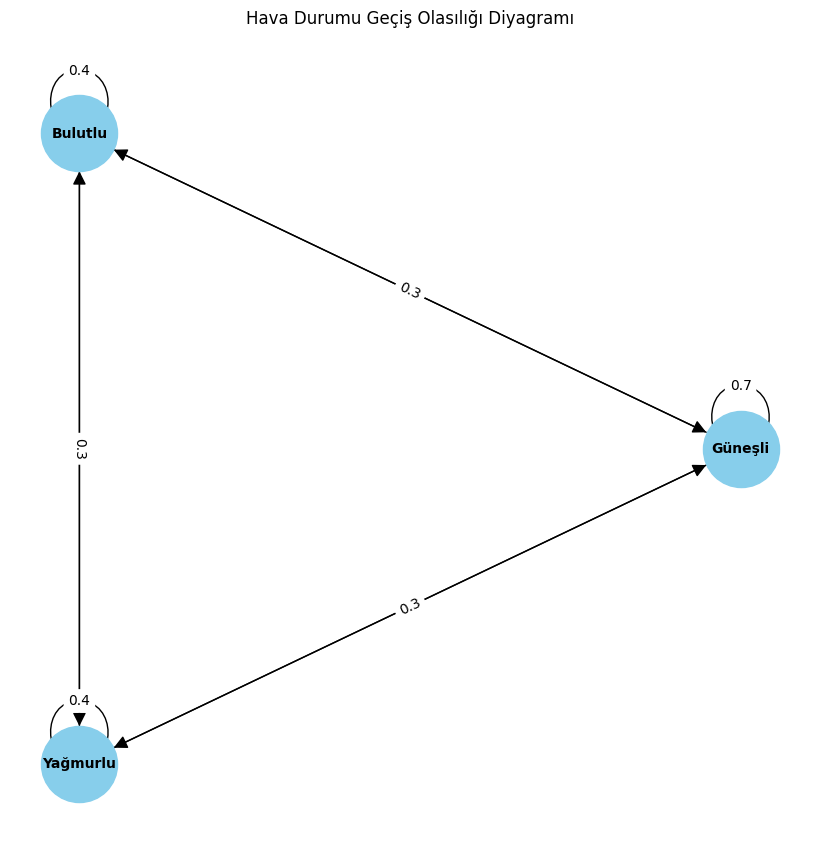

Geçiş Olasılıkları Matrisi (P):
Güneşli -> Güneşli: 0.7, Bulutlu: 0.2, Yağmurlu: 0.1
Bulutlu -> Güneşli: 0.3, Bulutlu: 0.4, Yağmurlu: 0.3
Yağmurlu -> Güneşli: 0.3, Bulutlu: 0.3, Yağmurlu: 0.4


In [17]:

# durumlar: 0 -> Güneşli, 1 -> Bulutlu, 2 -> Yağmurlu
states = ["Güneşli", "Bulutlu", "Yağmurlu"]

# geçiş olasılıkları matrisi
P = [
    [0.7, 0.2, 0.1],  # Güneşli -> Güneşli, Bulutlu, Yağmurlu
    [0.3, 0.4, 0.3],  # Bulutlu -> Güneşli, Bulutlu, Yağmurlu
    [0.3, 0.3, 0.4]   # Yağmurlu -> Güneşli, Bulutlu, Yağmurlu
]

# lasılık diyagramını oluşturma
G = nx.DiGraph()

for i in range(3):
    for j in range(3):
        G.add_edge(states[i], states[j], weight=P[i][j])

pos = nx.circular_layout(G)
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', arrowsize=20)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Hava Durumu Geçiş Olasılığı Diyagramı")
plt.show()

# Geçiş olasılıkları matrisini yazdırma
print("Geçiş Olasılıkları Matrisi (P):")
for i in range(3):
    print(f"{states[i]} -> {', '.join(f'{states[j]}: {P[i][j]}' for j in range(3))}")


### Geçiş olasılıkları matrisi

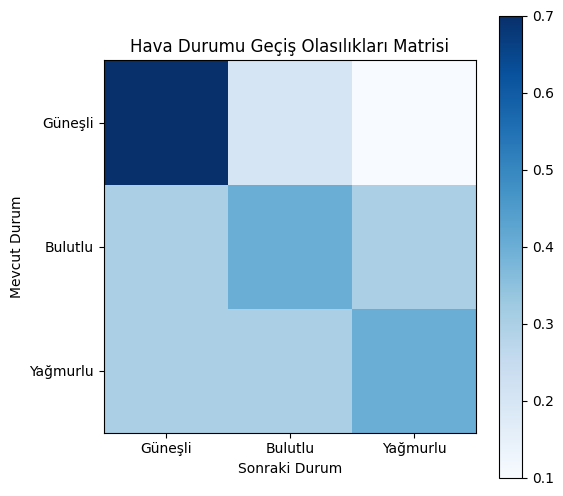

In [18]:



plt.figure(figsize=(6, 6))
plt.imshow(P, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(3), ["Güneşli", "Bulutlu", "Yağmurlu"])
plt.yticks(np.arange(3), ["Güneşli", "Bulutlu", "Yağmurlu"])
plt.xlabel('Sonraki Durum')
plt.ylabel('Mevcut Durum')
plt.title('Hava Durumu Geçiş Olasılıkları Matrisi')
plt.show()


### 4. Kapalı küme çeren bir Markov zincirine ait olasılık diyagramını çiziniz ve bir-adım geçiş  matrisi *(P)* ’yi tanımlayınız. 

Bu örnekte, trafik durumlarını ele alıyoruz ve bu durumlar arasındaki geçiş olasılıklarını bir-adım geçiş matrisi olarak temsil ediyoruz. Kapalı küme kavramı, her trafik durumundan diğer trafik durumlarına geçiş olasılıklarının toplamının 1 olduğu anlamına gelir. Yani, bir trafik durumundan başka bir trafik durumuna geçme olasılıklarının toplamı her zaman 1 olmalıdır.

Örneğin, trafik durumlarını ele aldığımızda, her bir durumun (örneğin, hafif trafik, orta trafik, yoğun trafik, kilitlenmiş trafik) diğer durumlara geçiş olasılıklarının toplamının her zaman 1 olduğunu görmeliyiz. Bu, trafik durumlarının birbirleriyle uyumlu bir şekilde değiştiği ve trafik akışının sürekli bir şekilde belirli bir döngüde ilerlediği anlamına gelir.


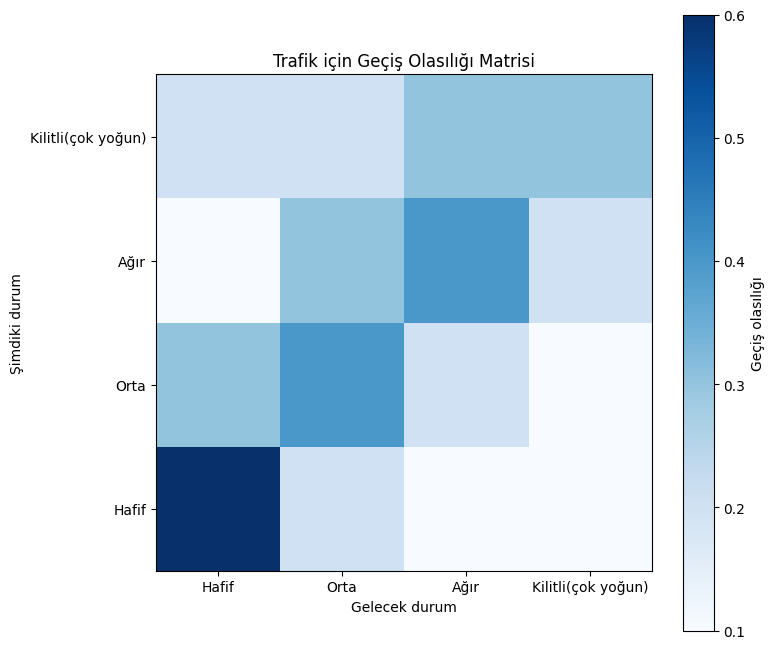

In [23]:

# Yeni bir-adım geçiş matrisi (P)
P_new = np.array([[0.6, 0.2, 0.1, 0.1],
                   [0.3, 0.4, 0.2, 0.1],
                   [0.1, 0.3, 0.4, 0.2],
                   [0.2, 0.2, 0.3, 0.3]])


plt.figure(figsize=(8, 8))
plt.imshow(P_new, cmap='Blues', origin='lower')
plt.colorbar(label='Geçiş olasılığı')
plt.title('Trafik için Geçiş Olasılığı Matrisi')
plt.xlabel('Gelecek durum')
plt.ylabel('Şimdiki durum')
plt.xticks(ticks=np.arange(4), labels=['Hafif', 'Orta', 'Ağır', 'Kilitli(çok yoğun)'])
plt.yticks(ticks=np.arange(4), labels=['Hafif', 'Orta', 'Ağır', 'Kilitli(çok yoğun)'])
plt.grid(False)
plt.show()


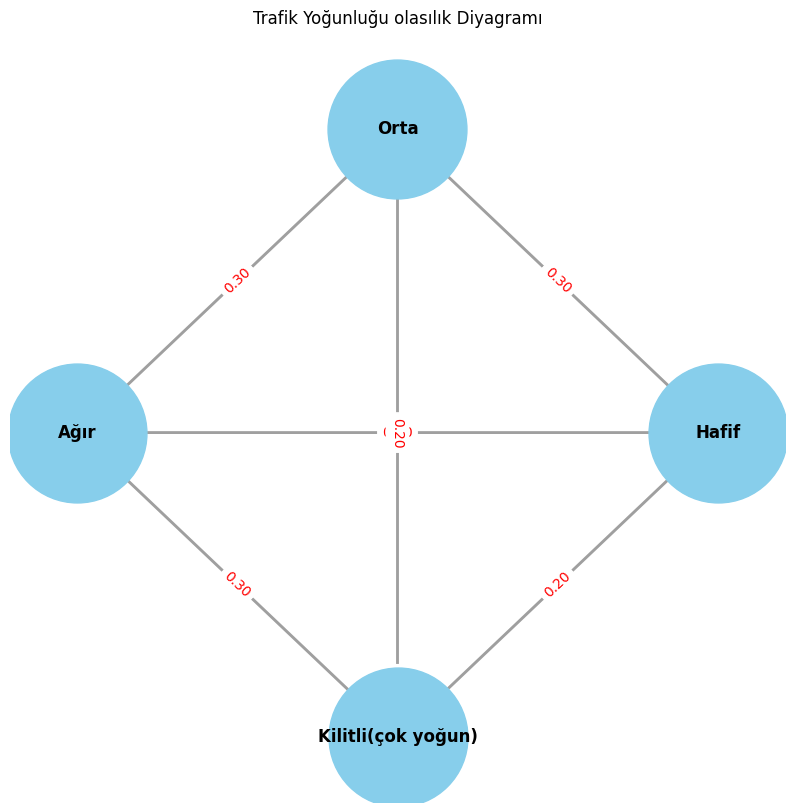

In [29]:

# Geçiş olasılık grafını oluştur
G = nx.DiGraph()
G.add_nodes_from(['Hafif', 'Orta', 'Ağır', 'Kilitli(çok yoğun)'])
for i, state in enumerate(['Hafif', 'Orta', 'Ağır', 'Kilitli(çok yoğun)']):
    for j, next_state in enumerate(['Hafif', 'Orta', 'Ağır', 'Kilitli(çok yoğun)']):
        G.add_edge(state, next_state, weight=P_new[i, j])

# Geçiş olasılık grafını çiz
plt.figure(figsize=(10, 10))
pos = nx.circular_layout(G)
edge_labels = {(n1, n2): f"{G[n1][n2]['weight']:.2f}" for n1, n2 in G.edges()}
nx.draw_networkx_nodes(G, pos, node_size=10000, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)
plt.title('Trafik Yoğunluğu olasılık Diyagramı')
plt.axis('off')
plt.show()


### 5) {Χ, η = 0,1,2,...} kesikli parametreli Markov zinciri için bir-adım geçiş matrisi ve ilk olasılık vektörü

**Durum uzayı:** S = {1,2,3}

                                                        Bir-adım geçiş matrisi:

| Durum | 1 | 2 | 3 |
|---|---|---|---|
| 1 | 1/3 | 2/3 | 0 |
| 2 | 1/2 | 0 | 1/2 |
| 3 | 0 | 1/2 | 1/2 |

                                                        İlk olasılık vektörü

                                                         π₀ = [1/2 1/3 1/6]


In [36]:


# Geçiş matrisi P
P = np.array([[1/3, 2/3, 0],
              [1/2, 0, 1/2],
              [3/4, 1/4, 0]])

# Başlangıç vektörü pi_0
pi_0 = np.array([1/2, 1/3, 1/6])

# a. P^3'ü 
P_3 = np.linalg.matrix_power(P, 3)
print("a. P^3:")
for i in P_3:
    print(i)

# b. P(X_3 = 1)
# İlk durum uzayındaki olasılıkları hesaplamak için pi_0 ile P^3'ü çarpıyoruz
P_X3_1 = pi_0.dot(P_3[:, 0])
print("b. P(X_3 = 1):", P_X3_1)

# c. P(X_0 = 1, X_4 = 2) olasılığı
# X_0 = 1 ve X_4 = 2 olma olasılığı P^4 matrisinin (0, 1) elemanı olacaktır
P_4 = np.linalg.matrix_power(P, 4)
P_X0_1_X4_2 = P_4[0, 1]
print("c. P(X_0 = 1, X_4 = 2):", P_X0_1_X4_2)

# d. P(X_1 = 2, X_2 = 3, X_3 = 1 | X_0 = 1) olasılığı
# X_1 = 2, X_2 = 3, X_3 = 1 olma olasılığı P^3 matrisinin (1, 0) elemanı olacaktır.
P_X1_2_X2_3_X3_1_given_X0_1 = P_3[1, 0]
print("d. P(X_1 = 2, X_2 = 3, X_3 = 1 | X_0 = 1):", P_X1_2_X2_3_X3_1_given_X0_1)

# e. P(X_12 = 1 | X_5 = 3, X_10 = 1) olasılığı
# X_12 = 1 olma olasılığı P^7 matrisinin (2, 0) elemanı olacaktır
P_7 = np.linalg.matrix_power(P, 7)
P_X12_1_given_X5_3_X10_1 = P_7[2, 0]
print("e. P(X_12 = 1 | X_5 = 3, X_10 = 1):", P_X12_1_given_X5_3_X10_1)


a. P^3:
[0.50925926 0.37962963 0.11111111]
[0.40972222 0.36111111 0.22916667]
[0.46875 0.28125 0.25   ]
b. P(X_3 = 1): 0.46932870370370366
c. P(X_0 = 1, X_4 = 2): 0.3672839506172839
d. P(X_1 = 2, X_2 = 3, X_3 = 1 | X_0 = 1): 0.4097222222222222
e. P(X_12 = 1 | X_5 = 3, X_10 = 1): 0.466236255787037
